<a href="https://colab.research.google.com/github/myriamnavas/markov-marketing-attribution-model/blob/main/Markov_marketing_attribution_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Análisis de Atribución de Marketing con Cadenas de Markov**




En este notebook explicaremos paso a paso cómo implementar un modelo de atribución de marketing basado en cadenas de Markov. Este enfoque nos permite analizar el mérito de las conversiones a los diferentes canales de marketing o diferentes campañas de una manera que tiene en cuenta todo el recorrido del cliente, en lugar de asignar todo el mérito al primer o último toque.

El objetivo es proporcionar una herramienta capaz de dar sentido al dilema de la atribución donde cada plataforma que usamos mide de manera diferente. Este modelo no resuelve al 100% esta situación (para eso están los MMM) ya que toma los datos de base del informe de rutas de atribución de Google Analytics 4 o de Google Ads pero ofrece una información muy valiosa para entender cómo fluyen las campañas con los diferentes canales existentes dentro del mix de estrategias de marketing.


El modelo de atribución que se propone está basado en el método de las cadenas de Markov con las siguientes particularidades:


1.   **Considera el recorrido completo del usuario**: A diferencia de los modelos simples, evalúa todas las interacciones que llevaron a la conversión.
2.   **Combina diferentes enfoques:** Esta propuesta integra tres modelos, el removal effect, el first touch y un método "balanced" que integra tanto el efecto de eliminación como el de primer contacto en una proporción 40%/60%. Esta proporción está pensada para darle mayor peso a los canales de entrada, tradicionalmente minusvalorados por GA4.
3.  **Incluye un proceso de convergencia:** Al probar distintos números de iteraciones, comprobamos cuándo los resultados dejan de cambiar significativamente, logrando un buen equilibrio entre precisión y tiempo de espera.
4. **Visualización clara:** El diagrama Sankey muestra de manera intuitiva cómo fluyen los usuarios entre los diferentes canales antes de convertir.

Para implementar este modelo con tus propios datos, necesitarás un CSV con las columnas 'path' y 'conversions', donde:


*   **'path'** contiene la secuencia de canales separados por el separador (por defecto ' > ')   
*   **'conversions'** indica el número de conversiones para cada ruta

Este enfoque puede ayudarte a entender el customer journey y a distribuir de manera más justa el presupuesto de marketing entre los diferentes canales, basándote en su contribución a las conversiones.

En este mismo repositorio tienes un archivo csv para que puedas probar el modelo.

**Nota:** el modelo se ha probado con hasta 16 canales diferentes tardando un total de aproximadamente 45 minutos en pasar el modelo completo. Con un menor número de canales no son necesarias tantas iteraciones. Se recomienda empezar con secuencias de iteraciones bajas e ir ampliando para ajustar la convergencia del modelo.

**1. Configuración inicial y carga de librerías**  

Primero, cargaremos todas las librerías necesarias y configuraremos algunos parámetros globales.

In [ ]:
#Importación de librerías

import pandas as pd
import numpy as np
from collections import defaultdict
import time
import matplotlib.pyplot as plt
import plotly.graph_objects as go


**2. Conexión con Drive**  
Montamos la conexión con Drive para que puedas ejecutar el modelo desde el Colab.


In [ ]:
# Mounting the connection with Drive.
from google.colab import drive
drive.mount('/content/drive')

**3. Configuración de parámetros**  
Establecemos los parámetros que controlarán la ejecución del modelo.

In [ ]:
# -------------------------------
# CONFIGURACIÓN
# -------------------------------

# Fijar la semilla para reproducibilidad
np.random.seed(42)

# Iteraciones a probar
ITERATIONS_TO_TEST = [50000, 75000, 100000, 125000]

# Variables globales para almacenar los resultados de atribución
removal_attribution_global = {}
first_touch_attribution_global = {}

# Umbral mínimo de atribución
MIN_ATTRIBUTION = 0.001

# Método de atribución
ATTRIBUTION_METHOD = 'balanced'

# Ruta del archivo CSV con rutas y conversiones
ruta_csv = "PON_AQUI_LA_RUTA_DE_TU_ARCHIVO_DE_RUTAS.csv"  # Ajusta esta ruta a la ubicación del archivo en tu sistema

# Separador entre canales
separator = ' > '

**4. Carga y procesamiento de datos**  
La siguiente función se encarga de cargar los datos desde un CSV y procesarlos para crear la matriz de transición que utilizará la cadena de Markov.


In [ ]:
# -------------------------------
# FUNCIONES
# -------------------------------

def load_and_process_data(csv_path, separator):
    """Carga y procesa los datos de rutas de conversión.

    Args:
        csv_path: Ruta al archivo CSV con los datos
        separator: Separador entre canales en las rutas

    Returns:
        transition_matrix: Matriz de transición para la cadena de Markov
        channel_counts: Contador de apariciones de cada canal
        transition_counts: Contador de transiciones entre canales
    """

    data = pd.read_csv(csv_path)

    # Verificar columnas necesarias
    if 'path' not in data.columns or 'conversions' not in data.columns:
        raise ValueError("El CSV debe contener las columnas 'path' y 'conversions'")

    # Contar apariciones y transiciones
    channel_counts = defaultdict(int)
    transition_counts = defaultdict(int)

    for _, row in data.iterrows():
        steps = row['path'].split(separator)
        steps = ['START'] + steps + ['CONVERSION']

        # Contar apariciones
        for step in steps:
            if step not in ['START', 'CONVERSION']:
                channel_counts[step] += row['conversions']

        # Contar transiciones
        for i in range(len(steps) - 1):
            transition_counts[(steps[i], steps[i+1])] += row['conversions']

    # Crear matriz de transición
    states = list(set([k[0] for k in transition_counts] + [k[1] for k in transition_counts]))
    transition_matrix = pd.DataFrame(0.0, index=states, columns=states)

    # Llenar la matriz de transición con probabilidades
    for (from_state, to_state), count in transition_counts.items():
        total_from = sum([v for (f, t), v in transition_counts.items() if f == from_state])
        if total_from > 0:
            transition_matrix.loc[from_state, to_state] = count / total_from

    return transition_matrix, channel_counts, transition_counts



**5. Simulación de probabilidad de conversión**  
Esta función simula caminos a través de la cadena de Markov para estimar la probabilidad de conversión.

In [ ]:
def simulate_conversion_prob(matrix, start_state, n_simulations):
    """
    Simula la probabilidad de conversión usando la matriz de transición de Markov.

    Args:
        matrix: Matriz de transición
        start_state: Estado inicial ('START')
        n_simulations: Número de simulaciones a realizar

    Returns:
        conversion_prob: Probabilidad estimada de conversión
        path_channels: Conjunto de canales visitados en las simulaciones
    """
    conversions = 0
    path_channels = set()

    for _ in range(n_simulations):
        state = start_state
        steps = 0
        MAX_STEPS = 100  # Límite para evitar bucles infinitos

        while steps < MAX_STEPS:
            # Obtener probabilidades de transición desde el estado actual
            probs = matrix.loc[state].values
            total_prob = probs.sum()

            # Si no hay probabilidades válidas, terminar
            if total_prob < 1e-10:
                break

            # Normalizar probabilidades
            probs = probs / total_prob

            try:
                # Elegir el siguiente estado según las probabilidades
                next_state = np.random.choice(matrix.columns, p=probs)
            except ValueError:
                break

            # Registrar canal si no es un estado especial
            if next_state != 'START' and next_state != 'CONVERSION':
                path_channels.add(next_state)

            # Manejar casos especiales
            if next_state == 'CONVERSION':
                conversions += 1
                break
            elif next_state == state or next_state == 'NULL':
                break
            else:
                state = next_state
                steps += 1

    # Calcular probabilidad como proporción de simulaciones que terminaron en conversión
    return conversions / n_simulations, path_channels

**6. Cálculo de atribución**  
Esta función implementa el cálculo de atribución utilizando diferentes métodos.

In [ ]:
def calculate_attribution(transition_matrix, n_simulations, method='balanced', min_attribution=0.001):
    """
    Calcula la atribución de cada canal según el método elegido.

    Args:
        transition_matrix: Matriz de transición de Markov
        n_simulations: Número de simulaciones a realizar
        method: Método de atribución ('balanced', 'removal_effect', o 'first_touch_bias')
        min_attribution: Valor mínimo de atribución

    Returns:
        attribution: Diccionario con la atribución de cada canal
        original_prob: Probabilidad de conversión original
        execution_time: Tiempo de ejecución
    """
    start_time = time.time()

    # Simular probabilidad original con todos los canales
    original_prob, channels_in_paths = simulate_conversion_prob(transition_matrix, 'START', n_simulations)

    # Calcular efectos para diferentes métodos de atribución
    removal_effect = {}
    first_touch_effect = {}

    # Para cada canal, calcular su efecto
    for channel in set(transition_matrix.columns) - {'START', 'CONVERSION', 'NULL'}:
        # 1. Método de removal effect (eliminación)
        # Crear una copia de la matriz y eliminar el canal
        matrix_copy = transition_matrix.copy()
        matrix_copy.loc[:, channel] = 0
        matrix_copy.loc[channel, :] = 0

        # Simular con el canal eliminado
        prob_without, _ = simulate_conversion_prob(matrix_copy, 'START', n_simulations)
        removal_effect[channel] = max(original_prob - prob_without, 0)

        # 2. Método de first-touch (primer contacto)
        first_touch_count = transition_counts.get(('START', channel), 0)
        total_first_touches = sum([v for (f, t), v in transition_counts.items() if f == 'START'])

        if total_first_touches > 0:
            first_touch_effect[channel] = first_touch_count / total_first_touches
        else:
            first_touch_effect[channel] = 0

    # Normalización de los efectos
    total_removal = sum(removal_effect.values())
    if total_removal > 0:
        removal_attribution = {k: v / total_removal for k, v in removal_effect.items()}
    else:
        removal_attribution = {k: 0 for k in removal_effect}

    total_first_touch = sum(first_touch_effect.values())
    if total_first_touch > 0:
        first_touch_attribution = {k: v / total_first_touch for k, v in first_touch_effect.items()}
    else:
        first_touch_attribution = {k: 0 for k in first_touch_effect}

    # Elegir método final de atribución
    if method == 'removal_effect':
        attribution = removal_attribution
    elif method == 'first_touch_bias':
        attribution = first_touch_attribution
    elif method == 'balanced':
        # Combinar ambos métodos (60% removal, 40% first-touch)
        attribution = {}
        for channel in set(removal_attribution.keys()) | set(first_touch_attribution.keys()):
            removal_value = removal_attribution.get(channel, 0)
            first_touch_value = first_touch_attribution.get(channel, 0)
            attribution[channel] = 0.6 * removal_value + 0.4 * first_touch_value

    # Aplicar umbral mínimo de atribución
    for channel in attribution:
        if attribution[channel] < min_attribution and channel_counts[channel] > 0:
            attribution[channel] = min_attribution

    # Renormalizar para que sumen 1
    total_attr = sum(attribution.values())
    attribution = {k: v / total_attr for k, v in attribution.items()}

    end_time = time.time()
    execution_time = end_time - start_time

    # Guardar los valores de atribución originales para uso posterior
    global removal_attribution_global, first_touch_attribution_global
    removal_attribution_global = removal_attribution
    first_touch_attribution_global = first_touch_attribution

    return attribution, original_prob, execution_time

**7. Ejecución del experimento principal**  
Ahora configuramos y ejecutamos el experimento completo, probando diferentes números de iteraciones.

In [ ]:
# -------------------------------
# EXPERIMENTO PRINCIPAL
# -------------------------------

print("Cargando y procesando datos...")
transition_matrix, channel_counts, transition_counts = load_and_process_data(ruta_csv, separator)
print(f"Matriz de transición creada con {len(transition_matrix.columns)} estados")

# Almacenar resultados para cada número de iteraciones
all_results = {}
execution_times = []
conversion_probs = []
nonzero_channels = []

# Comprobar consistencia con diferentes números de iteraciones
for n_iter in ITERATIONS_TO_TEST:
    print(f"\nProbando con {n_iter} iteraciones...")
    attribution, conv_prob, exec_time = calculate_attribution(
        transition_matrix,
        n_iter,
        method=ATTRIBUTION_METHOD,
        min_attribution=MIN_ATTRIBUTION
    )

    all_results[n_iter] = attribution
    execution_times.append(exec_time)
    conversion_probs.append(conv_prob)
    nonzero_channels.append(len([ch for ch, val in attribution.items() if val > 0]))

    print(f"Tiempo de ejecución: {exec_time:.2f} segundos")
    print(f"Probabilidad de conversión: {conv_prob:.6f}")
    print(f"Canales con atribución > 0: {nonzero_channels[-1]} de {len(attribution)}")

# Calcular diferencias entre ejecuciones consecutivas
differences = []
for i in range(1, len(ITERATIONS_TO_TEST)):
    prev_iter = ITERATIONS_TO_TEST[i-1]
    curr_iter = ITERATIONS_TO_TEST[i]

    # Seleccionar top 10 canales según la mayor iteración
    top_channels = sorted(all_results[curr_iter].items(), key=lambda x: x[1], reverse=True)[:10]
    top_channel_names = [ch for ch, _ in top_channels]

    # Calcular diferencia promedio para estos canales
    diffs = []
    for channel in top_channel_names:
        prev_value = all_results[prev_iter].get(channel, 0)
        curr_value = all_results[curr_iter].get(channel, 0)
        if curr_value > 0:  # Evitar división por cero
            pct_diff = abs(curr_value - prev_value) / curr_value * 100
            diffs.append(pct_diff)

    avg_diff = sum(diffs) / len(diffs) if diffs else 0
    differences.append(avg_diff)

    print(f"\nDiferencia promedio en top 10 canales entre {prev_iter} y {curr_iter} iteraciones: {avg_diff:.2f}%")



Cargando y procesando datos...
Matriz de transición creada con 12 estados

Probando con 50000 iteraciones...
Tiempo de ejecución: 124.20 segundos
Probabilidad de conversión: 0.714000
Canales con atribución > 0: 10 de 10

Probando con 75000 iteraciones...
Tiempo de ejecución: 179.60 segundos
Probabilidad de conversión: 0.713707
Canales con atribución > 0: 10 de 10

Probando con 100000 iteraciones...
Tiempo de ejecución: 225.35 segundos
Probabilidad de conversión: 0.711450
Canales con atribución > 0: 10 de 10

Probando con 125000 iteraciones...
Tiempo de ejecución: 285.47 segundos
Probabilidad de conversión: 0.711272
Canales con atribución > 0: 10 de 10

Diferencia promedio en top 10 canales entre 50000 y 75000 iteraciones: 6.80%

Diferencia promedio en top 10 canales entre 75000 y 100000 iteraciones: 21.28%

Diferencia promedio en top 10 canales entre 100000 y 125000 iteraciones: 11.67%


**8. Visualización con diagrama Sankey**  
Creamos un diagrama Sankey para visualizar el flujo entre canales.

In [ ]:
# -------------------------------
# VISUALIZACIÓN DE RESULTADOS
# -------------------------------

# ---------------------------------
# VISUALIZACIÓN – DIAGRAMA SANKEY
# ---------------------------------

# Crear el diagrama Sankey
labels = list(set([k[0] for k in transition_counts] + [k[1] for k in transition_counts]))
label_indices = {label: i for i, label in enumerate(labels)}

sources = [label_indices[k[0]] for k in transition_counts.keys()]
targets = [label_indices[k[1]] for k in transition_counts.keys()]
values = list(transition_counts.values())

# Verificar que tenemos datos válidos
if not sources or not targets or not values:
    print("⚠️ No hay suficientes datos para generar el diagrama Sankey")
else:
    try:
        fig = go.Figure(data=[go.Sankey(
            node=dict(
                pad=30,
                thickness=20,
                line=dict(color="black", width=0.5),
                label=labels,
            ),
            link=dict(
                source=sources,
                target=targets,
                value=values
            ))])

        fig.update_layout(
            title_text="Flujo de usuarios entre canales (Sankey)",
            font_size=12,
            height=800,  # Altura explícita
            width=1400   # Anchura explícita
        )

        # Guardar como HTML
        fig.write_html("sankey_markov.html")
        print("✅ Archivo 'sankey_markov.html' guardado correctamente.")

        # En Jupyter, esto mostrará el gráfico directamente
        fig.show()

    except Exception as e:
        print(f"❌ Error al crear el diagrama Sankey: {e}")
        print("   Verifica que los datos de transición son válidos.")



✅ Archivo 'sankey_markov.html' guardado correctamente.


**9. Visualización de resultados comparativos**  
Creamos gráficos para comparar los resultados con diferentes números de iteraciones.

✅ Gráfico 'comparacion_iteraciones.png' guardado correctamente.


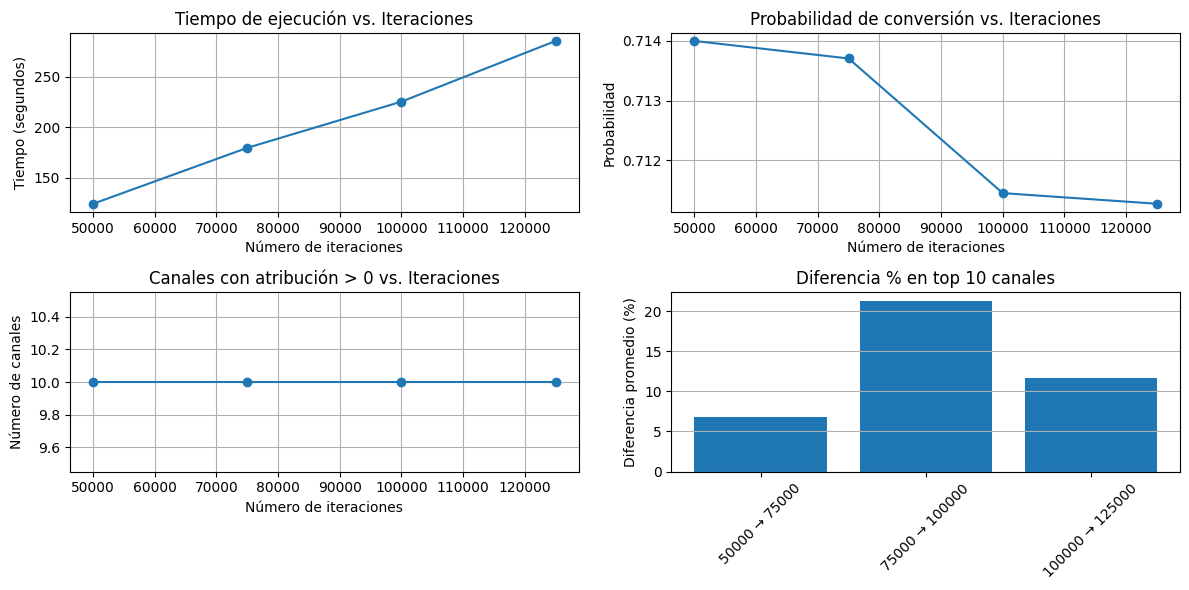

In [ ]:
# 1. Gráfico de tiempos de ejecución
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(ITERATIONS_TO_TEST, execution_times, 'o-')
plt.title('Tiempo de ejecución vs. Iteraciones')
plt.xlabel('Número de iteraciones')
plt.ylabel('Tiempo (segundos)')
plt.grid(True)

# 2. Gráfico de probabilidad de conversión
plt.subplot(2, 2, 2)
plt.plot(ITERATIONS_TO_TEST, conversion_probs, 'o-')
plt.title('Probabilidad de conversión vs. Iteraciones')
plt.xlabel('Número de iteraciones')
plt.ylabel('Probabilidad')
plt.grid(True)

# 3. Gráfico de canales con atribución no nula
plt.subplot(2, 2, 3)
plt.plot(ITERATIONS_TO_TEST, nonzero_channels, 'o-')
plt.title('Canales con atribución > 0 vs. Iteraciones')
plt.xlabel('Número de iteraciones')
plt.ylabel('Número de canales')
plt.grid(True)

# 4. Gráfico de diferencias porcentuales
if differences:
    plt.subplot(2, 2, 4)
    iter_pairs = [f"{ITERATIONS_TO_TEST[i-1]} → {ITERATIONS_TO_TEST[i]}" for i in range(1, len(ITERATIONS_TO_TEST))]
    plt.bar(iter_pairs, differences)
    plt.title('Diferencia % en top 10 canales')
    plt.ylabel('Diferencia promedio (%)')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')

plt.tight_layout()
plt.savefig('comparacion_iteraciones.png')
print("✅ Gráfico 'comparacion_iteraciones.png' guardado correctamente.")



**10. Generación de tablas comparativas**  
Creamos una tabla que muestra cómo cambian los resultados con diferentes números de iteraciones.

In [ ]:
# Crear tabla comparativa de los top 10 canales
final_results = all_results[ITERATIONS_TO_TEST[-1]]
top_channels = sorted(final_results.items(), key=lambda x: x[1], reverse=True)[:10]

comparison_data = []
headers = ['Canal'] + [f'{n_iter} iter.' for n_iter in ITERATIONS_TO_TEST] + ['Máx. diferencia %']

for channel, _ in top_channels:
    row = [channel]
    values = [all_results[n_iter].get(channel, 0) for n_iter in ITERATIONS_TO_TEST]
    row.extend([f"{val:.6f}" for val in values])

    # Calcular diferencia máxima
    if len(values) > 1 and values[-1] > 0:  # Comparar con el valor final como referencia
        max_diff = max([abs(val - values[-1]) / values[-1] * 100 for val in values[:-1]] or [0])
        row.append(f"{max_diff:.2f}")
    else:
        row.append("N/A")

    comparison_data.append(row)

# Crear DataFrame y guardar como CSV
comparison_df = pd.DataFrame(comparison_data, columns=headers)
comparison_df.to_csv('comparacion_atribucion.csv', index=False)
print("✅ Archivo 'comparacion_atribucion.csv' guardado correctamente.")



✅ Archivo 'comparacion_atribucion.csv' guardado correctamente.


**11. Exportación de resultados completos**  
Exportamos los resultados completos para cada conjunto de iteraciones.

In [ ]:
# Generar y guardar el archivo completo de atribución para cada número de iteraciones
for n_iter in ITERATIONS_TO_TEST:
    # Obtener resultados de esta iteración
    attribution = all_results[n_iter]

    # Crear DataFrame con todos los canales y sus métricas
    full_results = []
    for channel in attribution.keys():
        # Obtener valores de los diferentes métodos de atribución para esta iteración
        removal_value = removal_attribution_global.get(channel, 0)
        first_touch_value = first_touch_attribution_global.get(channel, 0)

        full_results.append({
            'channel': channel,
            'attribution': attribution.get(channel, 0),
            'apariciones': channel_counts.get(channel, 0),
            'removal_effect': removal_value,
            'first_touch': first_touch_value
        })

    # Crear y guardar DataFrame
    full_df = pd.DataFrame(full_results)
    full_df = full_df.sort_values(by='attribution', ascending=False)
    filename = f'atribucion_completa_{n_iter}_iter.csv'
    full_df.to_csv(filename, index=False)
    print(f"✅ Archivo '{filename}' guardado correctamente.")



✅ Archivo 'atribucion_completa_50000_iter.csv' guardado correctamente.
✅ Archivo 'atribucion_completa_75000_iter.csv' guardado correctamente.
✅ Archivo 'atribucion_completa_100000_iter.csv' guardado correctamente.
✅ Archivo 'atribucion_completa_125000_iter.csv' guardado correctamente.


**12. Conclusiones del análisis**
Finalmente, mostramos un resumen de las conclusiones del análisis.

In [ ]:
# Resumen de conclusiones
print("\n=== CONCLUSIONES ===")
print(f"Diferencia promedio entre {ITERATIONS_TO_TEST[0]} y {ITERATIONS_TO_TEST[-1]} iteraciones: {sum(differences)/len(differences):.2f}%")

if sum(differences)/len(differences) < 5:
    print(f"✅ {ITERATIONS_TO_TEST[0]} iteraciones parecen suficientes (diferencia < 5%)")
elif sum(differences)/len(differences) < 10:
    print(f"⚠️ {ITERATIONS_TO_TEST[0]} iteraciones muestran variación moderada (diferencia < 10%)")
else:
    print(f"❌ Se recomienda usar al menos {ITERATIONS_TO_TEST[-1]} iteraciones (diferencia > 10%)")

print("\nLas métricas sugeridas para decidir el número óptimo de iteraciones son:")
print("1. Estabilidad en los valores de atribución de los principales canales")
print("2. Número de canales con atribución no nula")
print("3. Tiempo de computación aceptable")

print("\n✅ Análisis completado. Revisa los archivos generados para tomar una decisión informada.")


=== CONCLUSIONES ===
Diferencia promedio entre 50000 y 125000 iteraciones: 13.25%
❌ Se recomienda usar al menos 125000 iteraciones (diferencia > 10%)

Las métricas sugeridas para decidir el número óptimo de iteraciones son:
1. Estabilidad en los valores de atribución de los principales canales
2. Número de canales con atribución no nula
3. Tiempo de computación aceptable

✅ Análisis completado. Revisa los archivos generados para tomar una decisión informada.


**13. Descarga de resultados**  
Al finalizar el análisis, puedes guardar los resultados en tu carpeta de descargas. Ejecuta la última línea de este código.

In [ ]:
# Descargar los resultados generados
from google.colab import files
import os

def descargar_resultados():
    print("\n=== DESCARGA DE RESULTADOS ===")
    print("Iniciando la descarga de los archivos generados...")

    # Lista de archivos generados para descargar
    archivos_a_descargar = [
        "sankey_markov.html",
        "comparacion_iteraciones.png",
        "comparacion_atribucion.csv"
    ]

    # Añadir archivos de atribución para cada iteración
    for n_iter in ITERATIONS_TO_TEST:
        archivos_a_descargar.append(f'atribucion_completa_{n_iter}_iter.csv')

    # Descargar cada archivo si existe
    archivos_descargados = 0
    for archivo in archivos_a_descargar:
        if os.path.exists(archivo):
            print(f"⬇️ Descargando {archivo}...")
            files.download(archivo)
            archivos_descargados += 1
        else:
            print(f"⚠️ No se encontró el archivo {archivo}")

    print(f"\n✅ Proceso de descarga completado. Se descargaron {archivos_descargados} archivos.")
    print("  Revisa la carpeta de descargas de tu navegador.")

# Ejecuta esta función cuando quieras descargar los resultados
#descargar_resultados()


=== DESCARGA DE RESULTADOS ===
Iniciando la descarga de los archivos generados...
⬇️ Descargando sankey_markov.html...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

⬇️ Descargando comparacion_iteraciones.png...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

⬇️ Descargando comparacion_atribucion.csv...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

⬇️ Descargando atribucion_completa_50000_iter.csv...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

⬇️ Descargando atribucion_completa_75000_iter.csv...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

⬇️ Descargando atribucion_completa_100000_iter.csv...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

⬇️ Descargando atribucion_completa_125000_iter.csv...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ Proceso de descarga completado. Se descargaron 7 archivos.
  Revisa la carpeta de descargas de tu navegador.
